# Monte Carlo Cross Validation for Watson Assistant (COVID-19)

<img src="images/Monte_Carlo_Header.PNG" style="width: 800px;">

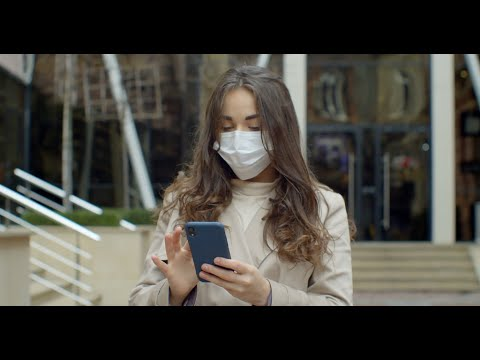

In [43]:
from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

display_yotube_video("https://www.youtube.com/watch?v=WzEj_m0hwF0", width=1000, height=400)

#### Import Libraries 

In [46]:
%matplotlib inline

import csv
import itertools
import json 
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import warnings
import base64
from IPython.display import HTML

warnings.filterwarnings('ignore')

from argparse import ArgumentParser
from datetime import datetime
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import AssistantV1
from IPython.display import display
from pandas.io.json import json_normalize
from sklearn.metrics import *
from sklearn.model_selection import *
from threading import Thread

In [6]:
from __future__ import print_function, division
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from watson_developer_cloud.assistant_v1 import CreateIntent, CreateExample
from itertools import groupby, repeat
from operator import itemgetter
from threading import Thread
from multiprocessing.pool import ThreadPool
import argparse
import os.path
import unicodecsv as csv

## 1. Connect to Watson Assistant 

#### Watson Assistant Authentication

<img src="images/IAM API WA.PNG" style="width: 800px;">

##### IAM Token

In [7]:
authenticator = IAMAuthenticator('user input')
assistant = AssistantV1(
    version='2018-07-10',
    authenticator=authenticator,)
assistant.set_service_url('https://api.us-south.assistant.watson.cloud.ibm.com/instances/sample')

#### [COVID-19] Router Workspace_EN

In [8]:
workspace = 'input workspace id' 

### 2. Cross Check Watson Assistant Workspace

In [9]:
response = assistant.message(workspace_id=workspace, # workspace_id = worspace channel that user want to connect
input={'text': 'What is the aim Covid19'}, 
                             alternate_intents= True)
dumps = json.dumps(response.get_result(), indent=2)
#print(dumps)

data = json.loads(dumps)
intent= data['intents'][0]['intent']
confidence = data['intents'][0]['confidence']
#output_key = data['output']['output_key']
entities = data['entities']
print("Intent detected: ", intent)
print("Confidence detected:", confidence)
#print("Output key detected:",output_key)
print("Entities detected:",entities)
#print('success')

Intent detected:  Covid_Description
Confidence detected: 0.2194818914683836
Entities detected: []


### 3. Upload from csv file
- Create intents column
- Create sample user as text column

In [10]:
import json
from pprint import pprint
with open('./Data_Test_Covid/skill_COVID_Bot_Skill_Master.json') as f: # USER INPUT - CHANGE THE FILE NAME HERE
    data = json.load(f)

def from_json(data):
    """
    retrieve the whole workspaces from json 
    """
    df2 = pd.DataFrame(columns = ['intent', 'text'])
    
    for i in range(len(data['intents'])):
        print("Scanned intent: {}".format(data['intents'][i]['intent']))
        for j in range(len(data['intents'][i]['examples'])):
            df2 = df2.append({'intent': data['intents'][i]['intent'],
                        'text': data['intents'][i]['examples'][j]['text']}
                       ,ignore_index=True)
    return df2 

df = from_json(data)

Scanned intent: Covid_Description
Scanned intent: Treatment_shortnessOfBreath
Scanned intent: TH_Embassy_Travel_News
Scanned intent: Treatment_info
Scanned intent: cdc_summary
Scanned intent: covid_thailand_self_quarantine
Scanned intent: Bot_Control_Approve_Response
Scanned intent: covid_thailand_quarantine_guidance
Scanned intent: General_Jokes
Scanned intent: cdc_facts
Scanned intent: travel_backtoUS
Scanned intent: covid-prevent-spread
Scanned intent: tx_count
Scanned intent: covid_thailand_novel
Scanned intent: COVID_Illness_Length
Scanned intent: covid-diagnosis
Scanned intent: covid_thailand_risk
Scanned intent: covid-flu-vs-common-cold
Scanned intent: covid_thailand_vaccine
Scanned intent: covid_thailand_declare_travel
Scanned intent: Bot_Control_Confirm_Presence
Scanned intent: Covid_Cleaning_Disinfecting
Scanned intent: covid_thailand_documents
Scanned intent: Goodbye
Scanned intent: Covid_Case_Count
Scanned intent: CDC_Info
Scanned intent: covid_thailand_cost
Scanned intent:

### 4. Train and Test Split

The session is that we want to make sure that each intent dimension is represented correctly in each train sets. 

Question validation will be randomly selected (without replacement) some fraction of your data to form the training set, and then assign the rest of the points to the test set. This process is then repeated multiple times, generating (at random) new training and test partitions each time. For example, suppose you chose to use 20% of question validation as test data in Watson Assistant. 

<img src="images/monte2.PNG" style="width: 500px;">

Monte Carlo is similar to K-Fold except the data sets are determined randomly. Shuffle the data randomly, pick the first 80% as training and designate the rest as testing data. Or, another way is to randomly split the data into an expected ratio. Then, you have one dataset for testing, and you repeat the shuffling multiple times so you can get as many splits as you want. Generally, the data sets are shuffled five times giving five accuracies to average together.

This provides the most random data sets of the three options, but the different splits could contain overlapping data since it is randomly selected.

Monte Carlo cross-validation (MCCV) = Repeated random sub-sampling validation (RRSSV)

<img src="images/MCCV_1.PNG" style="width: 400px;">

The 80% / 20% split is the most basic approach and probably the most common. Users hold back 20% of their GT (Ground Truth, or all the data points for the chatbot) rather than training with the entire GT. Then, after major changes are made to their development chatbot, they use the 20% GT to test the accuracy and ensure nothing has regressed since the last update. Accuracy of a chatbot can be defined as the percentage of utterances that had the correct intent returned.

### Chisquare

In [11]:
def create_folds(df):

    folds = []
    i = 0
    skf = ShuffleSplit(n_splits=1, train_size=0.80, test_size=0.20, random_state=np.random.RandomState(np.random.chisquare(len(df), int(len(df))).astype(np.int))) 
    for train_index, test_index in skf.split(df['text'], df['intent']):
        fold = {"train": train_index,
                "test": test_index}
        folds.append(fold)
        print("fold num {}: train set: {}, test set: {}".format(i+1,len(folds[i]["train"]), len(folds[i]["test"])))
        i += 1
    
    return folds

### 5. Create Monte Carlo workspaces
We want to use the folds generated previously to create the new Monte Carlo workspaces. 

<img src="images/WAS_Monte_Carlo_Workspace_Covid.PNG" style="width: 800px;">

In [12]:
k_fold_number = 1
def count_workspaces():

    response = assistant.list_workspaces().get_result()
    
    if(len(response['workspaces'])+k_fold_number <=20):
        print("You have space to perform the monte carlo test")
    else: 
        remove = len(response['workspaces'])+k_fold_number-20
        print("Be careful! The monte carlo test will make you exceed the 20 workspaces limit.")
        print("Make sure to remove {} workspaces before creating the monte carlo works.paces".format(remove))
    return 

count_workspaces()

You have space to perform the monte carlo test


#### Note : For ENGLISH Workspaces

In [13]:
def create_intents(train_index):

    intent_results = []
    for i in train_index:
        row = {}
        text = df.iloc[i]['text']
        intent = df.iloc[i]['intent']
        

        if not any(d['intent'] == intent for d in intent_results):
            row = { 'intent': intent, 
                    'examples': [ {'text': text } ] } 
        else:
            row = [d for d in intent_results if d.get('intent') == intent][0]
            intent_results[:] = [d for d in intent_results if d.get('intent') != intent]
            e = {'text': text}
            row['examples'].append(e)

        intent_results.append(row)
    
    return intent_results

def create_workspace(intents_json, fold_number):

    response = assistant.create_workspace(
        name='Monte Carlo test {}'.format(fold_number+1),
        #language = 'en'   # CHANGE LANGUAGE HERE (Default is 'en')
        description='workspace created for monte carlo testing', 
        intents = intents_json
    ).get_result()
    
    workspace_id = response.get('workspace_id')
    
    return workspace_id

def create_kfold_WA(folds):

    workspaces = []
    for i in range(len(folds)):
        print("creating monte carlo workspace {} out of {}".format(i+1, len(folds)))
        train = folds[i]["train"]
        intents = create_intents(train)
        workspace_id = create_workspace(intents, i)
        workspaces.append(workspace_id)
    
    return workspaces

folds = create_folds(df)
workspaces = create_kfold_WA(folds)

fold num 1: train set: 1013, test set: 254
creating monte carlo workspace 1 out of 1


#### 6. Check the status 
Before performing any test, we need to make sure that the workspaces have finished the training.

In [17]:
def check_status(workspaces): 

    for i in range(len(workspaces)):
        response = assistant.get_workspace(workspace_id = workspaces[i]).get_result()
        status = response['status']
        print("Monte Carlo workspace:{} ({}), Workspace is {}".format(i+1,workspaces[i], status))
        # The status can be: unavailable, training, non-existent, failed 
        if (status != 'Available'):
            print("The workspace is not available - check the details")
    return 

check_status(workspaces)

Monte Carlo workspace:1 (e50069fb-71b6-4abb-867f-12040e8ca743), Workspace is Available


In [18]:
def test_kfold(df_test, ws_id):

    results = pd.DataFrame([],columns = ['original_text','predicted_intent','actual_intent1',
                           'actual_confidence1','actual_intent2','actual_confidence2','actual_intent3',
                           'actual_confidence3'])

    for i in range(len(df_test)):

        text = df_test['text'][i]

        response = assistant.message(workspace_id=workspaces[ws_id], input={'text': text}, alternate_intents= True)
        dumps = json.dumps(response.get_result(), indent=2)
        
        if i != 0:
            print('.',end='')
            if i % 100 == 0: 
                print(i)

        data = json.loads(dumps)

        intent1= data['intents'][0]['intent']
        intent2= data['intents'][1]['intent']
        intent3= data['intents'][2]['intent']
        confidence1 = data['intents'][0]['confidence']
        confidence2 = data['intents'][1]['confidence']
        confidence3 = data['intents'][2]['confidence']

        results = results.append({
                'original_text': df_test["text"][i],
                'predicted_intent': df_test["intent"][i],
                'actual_intent1': intent1, 
                'actual_confidence1':confidence1, 
                'actual_intent2':intent2, 
                'actual_confidence2': confidence2, 
                'actual_intent3': intent3,
                'actual_confidence3': confidence3, 
            }, ignore_index=True)
        
    results.to_csv("./results/Chisquare/Monte_Carlo_{}_raw.csv".format(ws_id+1), encoding='utf-8')
    
    return results

def run_kfold_test(folds):

    test_results = []
    for i in range(len(folds)):
        print("\n")
        print("RUNNING Monte Carlo Cross Validation FOR FOLD NUMBER {}".format(i+1))
        test_index = folds[i]['test']
        df_test = df.iloc[test_index]
        df_test_reindexed = df_test.reset_index()
        results = test_kfold(df_test_reindexed, i)
        test_results.append(results)
    print("\n")
    print("FINISHED")
        
    return test_results

results_kfold = run_kfold_test(folds)



RUNNING Monte Carlo Cross Validation FOR FOLD NUMBER 1
....................................................................................................100
....................................................................................................200
.....................................................

FINISHED


### 7. Analyse the results 
Once we have the results for each fold, it's time to analyse the results. Let's prepare the data. 

In [19]:
def data_prep(dataframe):

    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    return dataframe

#### Collection of Metrics

<img src="images/Collection of Metrics.PNG" style="width: 800px;">

In [20]:
threshold = 0.68   #USER INPUT 
import warnings
warnings.filterwarnings('ignore')

def define_metrics(results_kfold):

    result_table = pd.DataFrame([],columns=["monte_carlo_round","total_tested","incorrect","accuracy", "precision","recall","fscore"])

    for i in range(len(results_kfold)):
        data = data_prep(results_kfold[i])
        incorrect_n = data.loc[data['actual_intent_correct']!=data["predicted_intent"]]
        incorrect_avg_conf = incorrect_n['actual_confidence1'].mean()
        precision,recall,fscore,support=precision_recall_fscore_support(data["actual_intent_correct"],data["predicted_intent"],average='weighted')
        accuracy = accuracy_score(data["actual_intent_correct"], data["predicted_intent"])
        result_table = result_table.append({
            "monte_carlo_round": i+1,
            "total_tested": len(results_kfold[i]),
            "incorrect": len(incorrect_n),
            "incorrect_avg_confidence": incorrect_avg_conf,
            "accuracy": accuracy, 
            "precision": precision, 
            "recall": recall, 
            "fscore": fscore
        }, ignore_index=True)
    
    return result_table

result_table = define_metrics(results_kfold)
result_table

,monte_carlo_round,total_tested,incorrect,accuracy,precision,recall,fscore,incorrect_avg_confidence
0,1.0,254.0,113.0,0.555118,0.433337,0.555118,0.476439,0.551417


<img src="images/F Score.PNG" style="width: 800px;">

Confusion matrix for the Intent matching


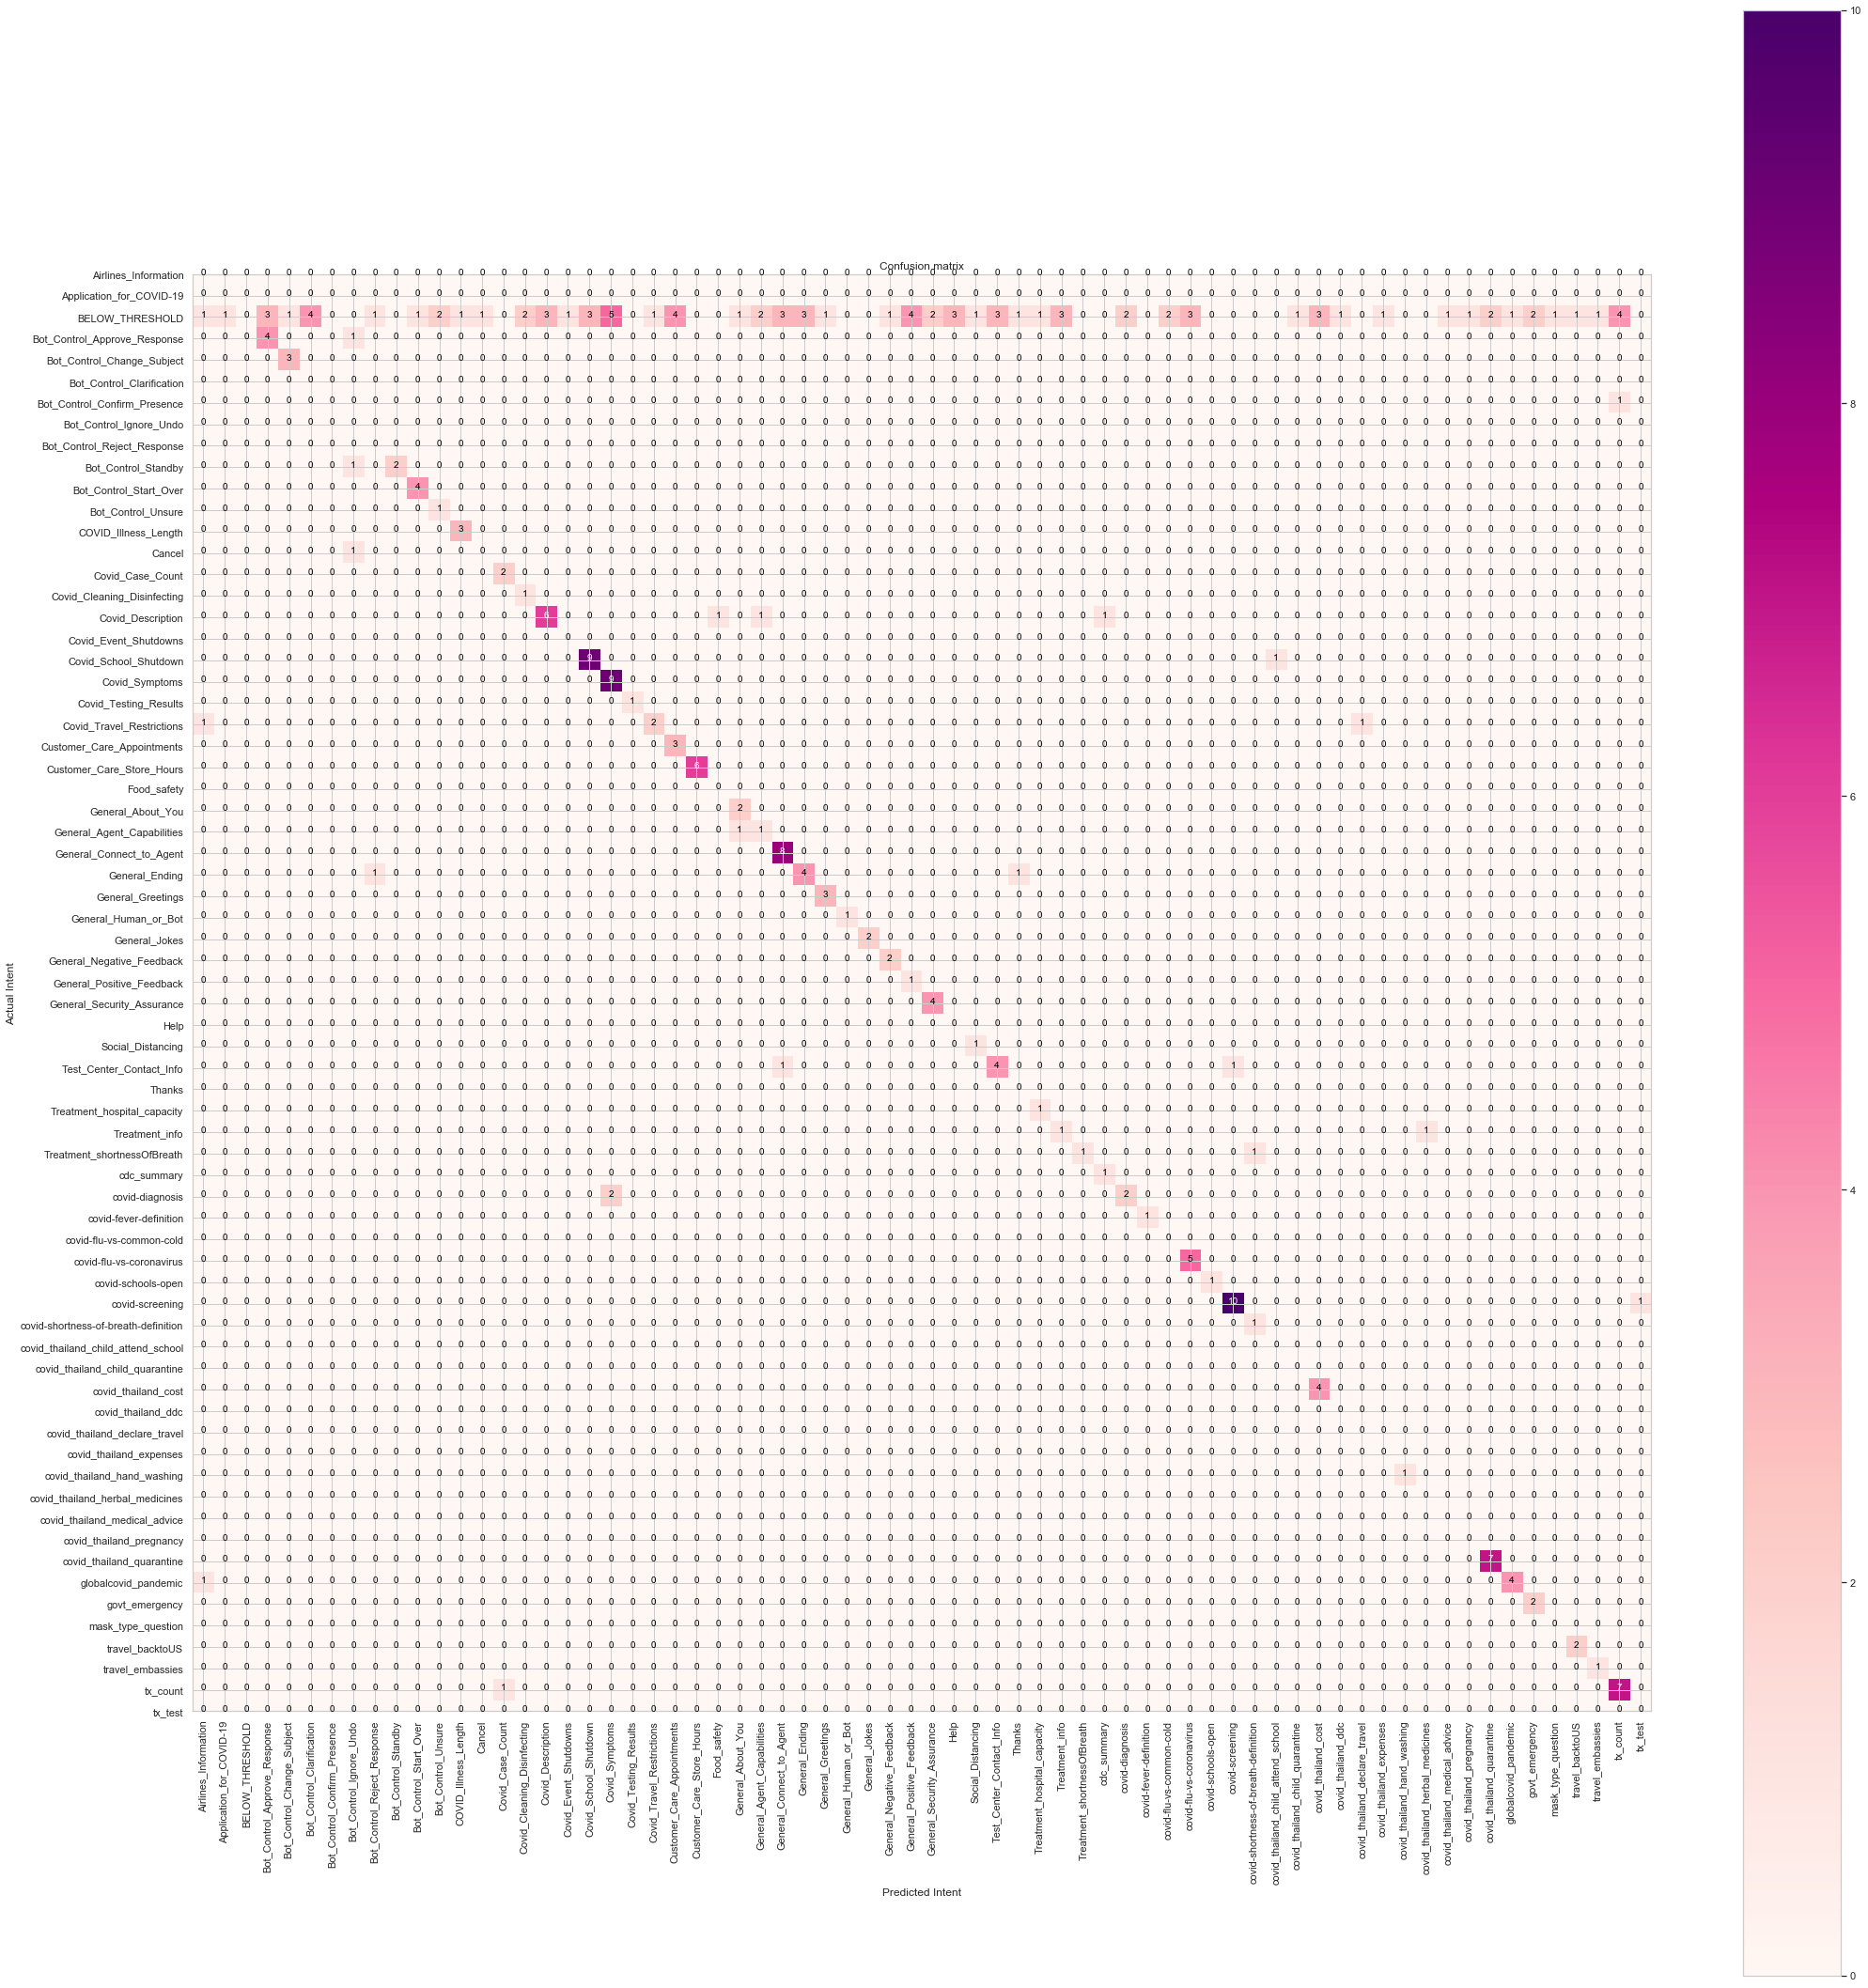

In [48]:
def data_prep_confusion_matrix(list_df):

    df = pd.concat(list_df) 
    dataframe = df.reset_index()
    
    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    matrix = confusion_matrix(dataframe["actual_intent_correct"], dataframe["predicted_intent"])
    
    lab1 = dataframe["actual_intent_correct"].unique()
    lab2 = dataframe["predicted_intent"].unique()
    lab = np.union1d(lab1,lab2)
    
    return matrix, lab, dataframe

matrix, lab, combined_df  = data_prep_confusion_matrix(results_kfold)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for the Intent matching")
    else:
        print('Confusion matrix for the Intent matching')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Intent')
    plt.xlabel('Predicted Intent')
    plt.tight_layout()
    
    return 
    
plt.figure(figsize=(30,30))
plot_confusion_matrix(matrix, classes=lab,
                      title='Confusion matrix')

In [22]:
print("OVERALL RESULTS")
accuracy = accuracy_score(combined_df["actual_intent_correct"], combined_df["predicted_intent"])
print("Accuracy:", accuracy)
precision,recall,fscore,support=precision_recall_fscore_support(combined_df["actual_intent_correct"],
                                                                combined_df["predicted_intent"],
                                                                average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("FScore:", fscore)

print("\n")
print("PER INENT - DETAILED RESULTS")
print(classification_report(combined_df["actual_intent_correct"], combined_df["predicted_intent"]))
report = classification_report(combined_df["actual_intent_correct"], combined_df["predicted_intent"])

OVERALL RESULTS
Accuracy: 0.5551181102362205
Precision: 0.433337239095113
Recall: 0.5551181102362205
FScore: 0.47643924098648505


PER INENT - DETAILED RESULTS
                                      precision    recall  f1-score   support

                Airlines_Information       0.00      0.00      0.00         0
            Application_for_COVID-19       0.00      0.00      0.00         0
                     BELOW_THRESHOLD       0.00      0.00      0.00        91
        Bot_Control_Approve_Response       0.57      0.80      0.67         5
          Bot_Control_Change_Subject       0.75      1.00      0.86         3
           Bot_Control_Clarification       0.00      0.00      0.00         0
        Bot_Control_Confirm_Presence       0.00      0.00      0.00         1
             Bot_Control_Ignore_Undo       0.00      0.00      0.00         0
         Bot_Control_Reject_Response       0.00      0.00      0.00         0
                 Bot_Control_Standby       1.00      0.67  

### Analysis of the Report 
1. Export the analysis above into a CSV - "classification_report.csv" 

In [49]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe_new = dataframe[dataframe["class"] != " BELOW_THRESHOLD"]
    #print(dataframe_new)
    dataframe_new.to_csv('./results/Chisquare/monte_carlo_classification_report.csv', index = False)
    
    return dataframe_new
    
report_df = classification_report_csv(report)

report_least = report_df.sort_values(by = ['f1_score']).reset_index(drop=True)
report_top = report_df.sort_values(by = ['f1_score'], ascending=False).reset_index(drop=True)

In [50]:
def create_download_link( df, title = "Download Monte Carlo Classification Report file", filename = "monte_carlo_classification_report.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df = report_df
create_download_link(df)

Text(0.5, 1.0, '5 Top Performing intents (F1_score)')

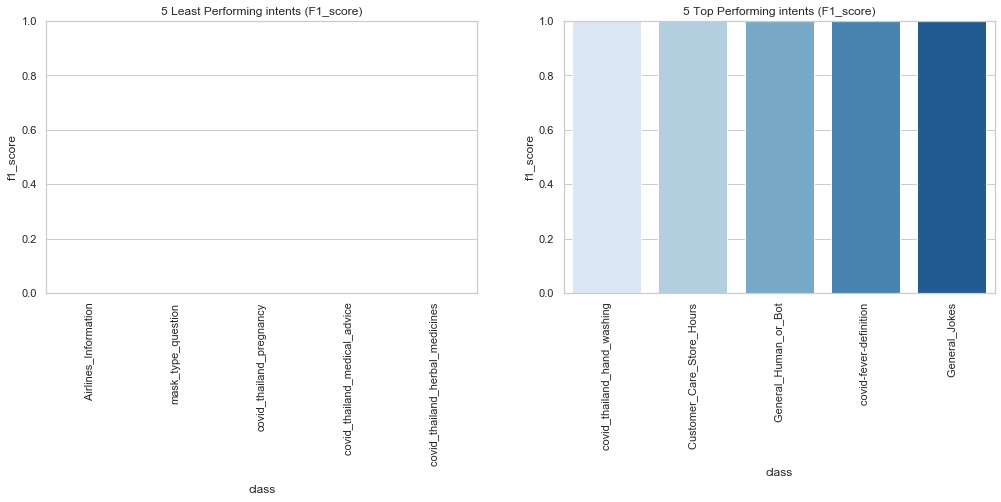

In [25]:
# Visualization of top intents 
import seaborn as sns
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(ncols=2 ,figsize=(17,5))
ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))

# worst performing intents 
sns.barplot(x="class", y="f1_score", data=report_least[:5], palette="Reds", ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("5 Least Performing intents (F1_score)")

# top performing intents
sns.barplot(x="class", y="f1_score", data=report_top[:5], palette="Blues", ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("5 Top Performing intents (F1_score)")


### 8. Analyse the Incorrect matches

<img src="images/Incorrect matches.PNG" style="width: 400px;">

Identified 3 types of different incorrect matches. 
1. **Incorrect intent was triggered with high confidence**: It is important to understand why the incorrect intent is sensitive to the testing phrase – an N-gram test can be helpful in such cases. This type of error has the priority, since it can have a bad influence on the chatbot’s performance.
2. **Incorrect intent was triggered with low confidence** : Since those intents were triggered with low confidence, this error has less priority compared to problem (1). However, an incorrect intent was still detected. – an N-gram test can be helpful in such cases. Further, more training is necessary in order to boost the confidence level of the correct intent and resolving the conflicts between both intents.
3. **Correct intent but with low confidence** : More training is needed in order to increase the confidence level of the correct intent.

### 8.1. Incorrect intent was triggered with high confidence 

In [51]:
def create_download_link( df, title = "Download Monte Carlo Wrong Intent High Confidence file", filename = "01.monte_carlo_wrong_intent_high_confidence.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df = incorrect1 = combined_df.loc[(combined_df["predicted_intent"]!=combined_df["actual_intent1"])&(combined_df["actual_confidence1"]>=threshold)]
if (len(incorrect1) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect1)))
    incorrect1.to_csv('./results/Chisquare/01.monte_carlo_wrong_intent_high_confidence.csv', index = False)
    print("File saved in 'results' - 01.monte_carlo_wrong_intent_high_confidence.csv")
create_download_link(df)

Detected: 22 samples
File saved in 'results' - 01.monte_carlo_wrong_intent_high_confidence.csv


### 8.2 Inorrect intent was triggered but with low confidence 

In [52]:
def create_download_link( df, title = "Download Monte Carlo Wrong Intent Low Confidence file", filename = "02.monte_carlo_wrong_intent_low_confidence.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df = incorrect2 = combined_df.loc[(combined_df["predicted_intent"]!=combined_df["actual_intent1"])&(combined_df["actual_confidence1"]<threshold)]

if (len(incorrect2) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect2)))
    incorrect2.to_csv('./results/Chisquare/02.monte_carlo_wrong_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 02.monte_carlo_wrong_intent_low_confidence.csv")
create_download_link(df)

Detected: 48 samples
File saved in 'results' - 02.monte_carlo_wrong_intent_low_confidence.csv


### 8.3. Correct intent was triggered but with low confidence 

In [53]:
def create_download_link( df, title = "Download Monte Carlo Correct Intent Low Confidence file", filename = "03.monte_carlo_correct_intent_low_confidence.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df = incorrect3 = combined_df.loc[(combined_df["predicted_intent"]==combined_df["actual_intent1"])&(combined_df["actual_confidence1"]<threshold)]

if (len(incorrect3) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect3)))
    incorrect3.to_csv('./results/Chisquare/03.monte_carlo_correct_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 03.monte_carlo_correct_intent_low_confidence.csv")
create_download_link(df)

Detected: 43 samples
File saved in 'results' - 03.monte_carlo_correct_intent_low_confidence.csv


### 9. Highlight possible Confused Intents
There are different ways to detect if intents are overlapping creating 'confusion' in the bot. This time we will use a pragmatic way: let's check the difference in confidence level between the first and second intent and see if it's less than a certain level (`threshold_confusion` e.g. 10%, 15%). If it is less, then maybe it's a good idea to investigate why the confidence levels are so close to each other and improve the Ground Truth of these intents. 

The first intent needs to be higher than the threshold determined at the beginning of this notebook (`threshold`).  

In [29]:
threshold_confusion = 0.68   ## USER CHOICE

In [54]:
def create_download_link( df, title = "Download Monte Carlo Intent Overlap file", filename = "04.monte_carlo_monte_carlo_intent_overlap.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

confusion1 = combined_df.loc[(combined_df["actual_confidence1"]-combined_df["actual_confidence2"]<threshold_confusion)&(combined_df["actual_confidence1"]>threshold)]

if (len(confusion1) == 0 ): 
    print ("No overlapping intents found")
else: 
    print("Detected: {} samples".format(len(confusion1)))
    confusion1.to_csv('./results/Chisquare/04.monte_carlo_intent_overlap.csv', index = False)
    print("File saved in 'results' - 04.monte_carlo_monte_carlo_intent_overlap.csv")
    print("\n")
    print("Show unique pairings")
    df = confusion1[['actual_intent1', 'actual_intent2']]
    print(df.groupby(['actual_intent1', 'actual_intent2']).size())
create_download_link(confusion1)

Detected: 117 samples
File saved in 'results' - 04.monte_carlo_monte_carlo_intent_overlap.csv


Show unique pairings
actual_intent1                actual_intent2             
Bot_Control_Approve_Response  Bot_Control_Start_Over         1
                              Customer_Care_Appointments     1
                              Goodbye                        1
Bot_Control_Change_Subject    Bot_Control_Clarification      1
                              Customer_Care_Appointments     1
                                                            ..
travel_embassies              travel_backtoUS                1
tx_count                      Covid_Case_Count               2
                              Covid_Cleaning_Disinfecting    1
                              Covid_Description              1
                              govt_emergency                 1
Length: 107, dtype: int64


### Last Step: Delete the workspace 
Once you have finished testing, this will help delete the additional testing workspace from Watson Assistant.

In [31]:
def delete_kfold_workspaces(workspaces):

    for i in range(len(workspaces)):
        print("deleting workspace {} out of {}: {}".format(i+1, len(workspaces), workspaces[i]))
        response = assistant.delete_workspace(
                workspace_id = workspaces[i]).get_result()
    return 

delete_kfold_workspaces(workspaces)

deleting workspace 1 out of 1: e50069fb-71b6-4abb-867f-12040e8ca743
